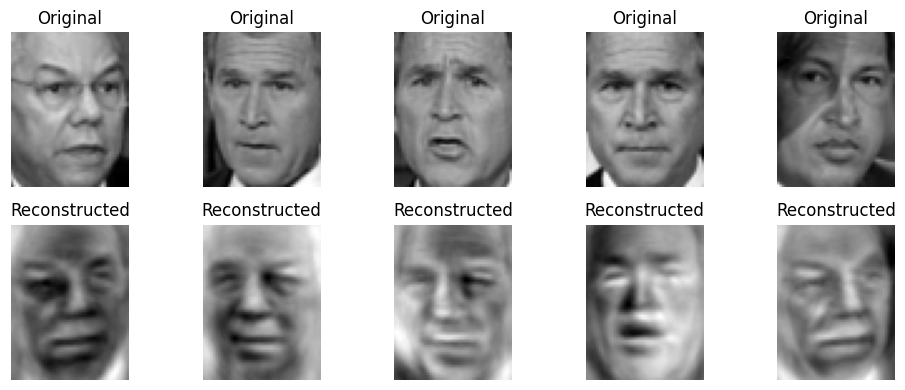

Fitting 5 folds for each of 10 candidates, totalling 50 fits
                   precision    recall  f1-score   support

     Ariel Sharon       0.78      0.58      0.67        12
     Colin Powell       0.88      0.86      0.87        51
  Donald Rumsfeld       0.64      0.64      0.64        25
    George W Bush       0.78      0.90      0.83        98
Gerhard Schroeder       0.65      0.62      0.63        21
      Hugo Chavez       1.00      0.47      0.64        15
Junichiro Koizumi       0.90      0.90      0.90        10
       Tony Blair       0.78      0.74      0.76        38

         accuracy                           0.79       270
        macro avg       0.80      0.71      0.74       270
     weighted avg       0.79      0.79      0.78       270



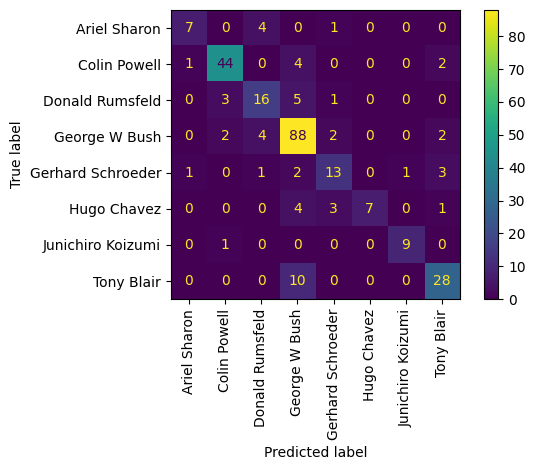

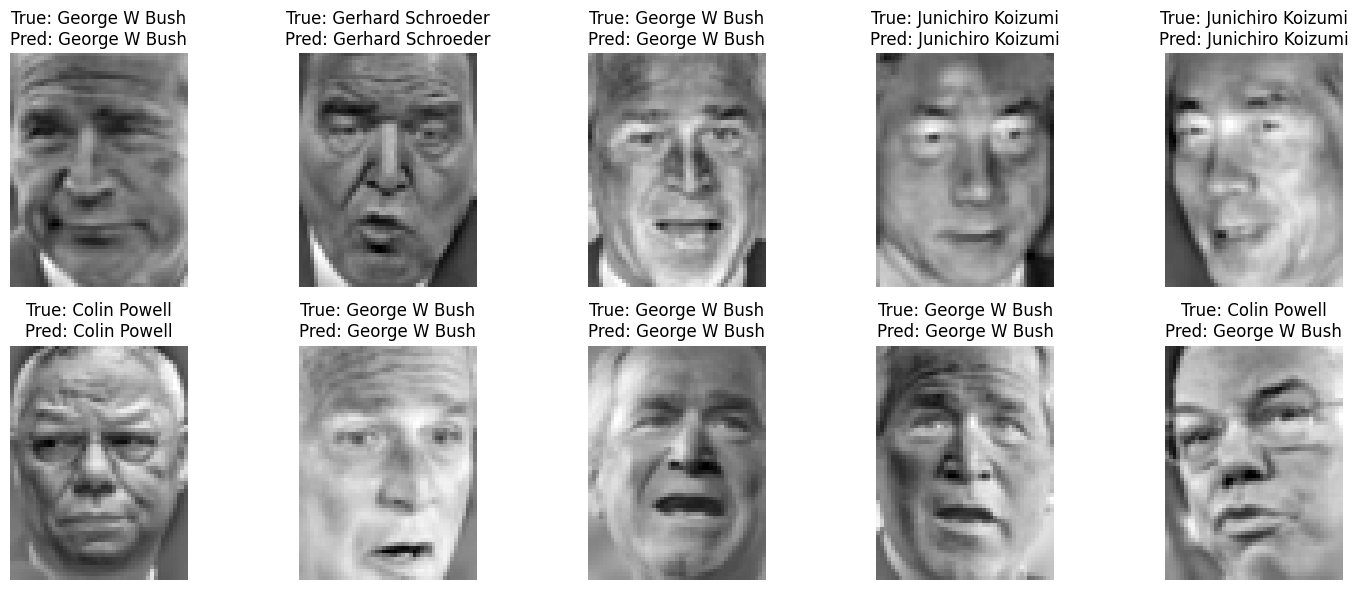

In [20]:
# @title
import numpy as np
from scipy.stats import loguniform
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# Fetch the data from the database
def dataFetcher():
    lfw = fetch_lfw_people(min_faces_per_person=60, resize=0.5)

    # Extract data, images, and targets
    X = lfw.data  # m * n array containing m images and n features (n = h * w)
    images = lfw.images
    Y = lfw.target
    names = lfw.target_names

    return X, Y, names, images

# Perform PCA for dimensionality reduction
def perform_pca(data, num_components):
    # Compute the covariance matrix
    mean = np.mean(data, axis = 0)
    centered_data = data - mean
    covariance_matrix = np.cov(centered_data, rowvar=False)

    # Compute eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

    # Sort eigenvalues and eigenvectors in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]

    # Select the top num_components eigenvectors
    selected_vectors = eigenvectors[:, :num_components]  # Select the top principal components
                                                         # Select all rows (features), but select only the first "n_component" columns)
                                                         # Since the first n_components are those with the greatest eigevalues,
                                                         # they are the principal componenets!

    return selected_vectors, mean

# Encode data using PCA
def encode_data(data, eigenvectors):
    return np.dot(data, eigenvectors)  # Find the projections of the data

# Decode data back to the original space
def decode_data(encoded_data, eigenvectors):
    return np.dot(encoded_data, eigenvectors.T)

# Visualize original and reconstructed images
def visualize_faces(original_images, reconstructed_images, image_shape, num_images=5):
    plt.figure(figsize=(10, 4))

    for i in range(num_images):
        # Original image
        plt.subplot(2, num_images, i + 1)
        plt.imshow(original_images[i].reshape(image_shape), cmap='gray')
        plt.axis('off')
        plt.title("Original")

        # Reconstructed image
        plt.subplot(2, num_images, i + 1 + num_images)
        plt.imshow(reconstructed_images[i].reshape(image_shape), cmap='gray')
        plt.axis('off')
        plt.title("Reconstructed")

    plt.tight_layout()
    plt.show()

# Show faces with predictions
def visualize_predictions(images, true_labels, predicted_labels, names, image_shape, num_images=10):
    plt.figure(figsize=(15, 6))
    for i in range(num_images):
        plt.subplot(2, num_images // 2, i + 1)
        plt.imshow(images[i].reshape(image_shape), cmap='gray')
        plt.title(f"True: {names[true_labels[i]]}\nPred: {names[predicted_labels[i]]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()


# Main function
def main():
    # Load data
    data, targetIDs, targetNames, images = dataFetcher()
    image_shape = images.shape[1:]  # Get the shape of a single image

    featureNum = data.shape[1]  # No. of features (pixels)
    imageNum = data.shape[0]  # No. of images
    peopleNum = targetNames.shape[0]  # No. of people

    # Split into train and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(data, targetIDs, test_size=0.2, random_state=42)

    # Scale the data (PCA and SVM are sensitive to scaling)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)  # Set the scaler such that it scales any data (particularly the test data)
                                             # according to the mean and variance of X_train (training data)

    X_test = scaler.transform(X_test)        # scale the test data ("transform it") according to the mean and variance of X_train

    # Perform PCA and reduce dimensions
    num_components = 50  # Number of principal components
    eigenvectors, mean = perform_pca(X_train, num_components)

    # Encode and decode test data
    encoded_train_data = encode_data(X_train - mean, eigenvectors) # Project the images onto the principal components of the covariance matrix
    encoded_test_data = encode_data(X_test - mean, eigenvectors)

    X_train_pca =  encoded_train_data
    X_test_pca = encoded_test_data

    reconstructed_data = decode_data(encoded_train_data, eigenvectors) + mean
    reconstructed_images = reconstructed_data.reshape(-1, image_shape[0], image_shape[1])

    # Visualize original and reconstructed images
    visualize_faces(images[:len(reconstructed_images)], reconstructed_data, image_shape)

    # Choose a module to train the data on
    classifier = RandomizedSearchCV(SVC(kernel="rbf", class_weight="balanced"),
                                    # Hyperparameters. The support vector machine randomly searches (tries different combinations of hyperparameters)
                                    # until it finds the combination that produces and the best model (estimator) and the best parameters.

                                    {"C" : loguniform(1e3, 1e5),
                                    # Regularization parameter: Low value, low generalization, risks overfitting.
                                    # High value, high generalization, avoids overfitting

                                    "gamma" : loguniform(1e-4, 1e-1)},
                                    # The influence of a point on the function (think of the function as a curve, gamma is
                                    # the gravitational field of the point, or how much this point attracts the curve to it
                                    # or influences the function)

                                    n_iter=10,  # Reduced iterations for faster training
                                    n_jobs=-1,  # Parallel processing
                                    verbose=2  # Progress monitoring
                                    )
    try:
              classifier.fit(X_train_pca, Y_train) # Store the best model (estimator), best parameters and cross validation data in the classifier obj.
    except KeyboardInterrupt:
              print("Training interrupted. Returning partially trained model.")

    # Make predictions
    Y_prediction = classifier.predict(X_test_pca) # The output of this function is the predictions made by the classifier
                                                  # when the x_test values are inserted
    # Show the classification report
    report = classification_report(Y_test, Y_prediction, target_names=targetNames)
    print(report)

    # Display confusion matrix
    ConfusionMatrixDisplay.from_estimator(
        classifier, X_test_pca, Y_test, display_labels=targetNames, xticks_rotation="vertical"
    )
    plt.tight_layout()
    plt.show()

    # Show predictions with images
    visualize_predictions(X_test, Y_test, Y_prediction, targetNames, image_shape, num_images=10)
if __name__ == "__main__":
    main()
